In [11]:
import numpy as np
from pandas import unique
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from matplotlib.table import Table

In [12]:
def normalizeDataset(data):
    normalized_data = np.copy(data)
    min_vals = np.min(data[:, :-1], axis=0)
    max_vals = np.max(data[:, :-1], axis=0)
    normalized_data[:, :-1] = (data[:, :-1] - min_vals) / (max_vals - min_vals)
    return normalized_data

In [13]:
def loadDataset():
    # Load the dataset
    data = pd.read_csv('dataset/titanic.csv')
    
    # Drop the 'Name' column
    data.drop('Name', axis=1, inplace=True)
    
    # Handling categorical data: Convert 'Sex' to binary (0 for male, 1 for female)
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
    
    # Convert the DataFrame to a NumPy array and move 'Survived' to the last column
    np_data = data.to_numpy()
    np_data = np.roll(np_data, shift=-1, axis=1)  # Move 'Survived' to the last column
    
    return np_data


In [14]:
def printWgtData(data):
    for keys in data:
        print("\n Weights " + str(keys+1) + ":" )
        print(data[keys].T)

In [15]:
def printInst(data, phrase, ):
    for i in range(data.shape[0]):
        print("Instance " + str(i) + phrase + " :" + str(data[i]))

In [16]:
def crossValidate(dataset, classes, k=10):
    class_map = {cls: [] for cls in classes}
    for entry in dataset:
        class_map[entry[-1]].append(entry)
    folds = [[] for _ in range(k)]
    for entries in class_map.values():
        for idx, entry in enumerate(entries):
            folds[idx % k].append(entry)
    return folds

In [17]:
def hotEncode(dataset, cat_cols):
    transformed = None
    used = False

    for i in range(dataset.shape[1] - 1):  # Iterate through all columns except the last one
        ohe = OneHotEncoder(categories='auto')
        if not used:
            if cat_cols[i]:
                hot_row = ohe.fit_transform(dataset[:, i].reshape(-1, 1)).toarray()
                transformed = hot_row
            else:
                transformed = dataset[:, i].reshape(-1, 1)
            used = True
        else:
            if cat_cols[i]:
                hot_row = ohe.fit_transform(dataset[:, i].reshape(-1, 1)).toarray()
                transformed = np.hstack((transformed, hot_row))
            else:
                transformed = np.hstack((transformed, dataset[:, i].reshape(-1, 1)))

    return np.hstack((transformed, dataset[:, -1].reshape(-1, 1)))  # Append the last column (target variable)


In [18]:
class Neural_Network:
    def __init__(self, learning_rate, lmda, epochs, printLogs=False):
        self.alpha = learning_rate
        self.lamdba = lmda
        self.print = printLogs
        self.epochs = epochs

    def updateParams(self, training, train_labels, layer_dim, class_label):
        self.training = training
        self.train_labels = train_labels
        self.layer_dim = layer_dim
        self.weights = {}
        self.classMp = {class_label [x]:x for x in range(len(class_label))}
  
    def selectWgts(self, weights):
        for x in range(len(self.layer_dim) - 1):
            self.weights[x] = weights[x].reshape(self.layer_dim[x+1], self.layer_dim[x] + 1).T
        if self.print:
            print("\n"+ "-" * 60)
            printWgtData(self.weights)
            
    def generateWgts(self):
        for x in range(len(self.layer_dim) - 1):
            self.weights[x] = np.random.uniform(low=-1, high=1, size=(self.layer_dim[x+1], self.layer_dim[x] + 1)).T

    def sigmoid(self, in_layer, derivative=False):
        if derivative:
            return  in_layer * (1 - in_layer)    
        return 1/(1+np.exp(-in_layer))
    
    def forwardPropagate(self, input):
        
        vector = {}
        vector[0] = input
        if self.print:
            print("\n"+ "-" * 60 + "\nForward propagating the inputs"+ " :")
            printInst(vector[0], "")


        for x in range(len(self.weights)):
            temp = np.concatenate((np.full((vector[x].shape[0], 1),1), vector[x]), axis=1)
            if self.print:
                print("\n"+ "-" * 60 + "\nForward propagating - a" + str(x+1) + " :")
                printInst(temp, "")
            dot = temp.dot(self.weights[x])

            if self.print:
                print("\n"+ "-" * 60 + "\nForward propagating - z" + str(x+1) + " :")
                printInst(dot, "")

            vector[x+1] = self.sigmoid(dot)

        if self.print:
            print("\n"+ "-" * 60 + "\nForward propagating - a" + str(len(vector)) + " :")
            printInst(vector[len(vector)-1], "")
        if self.print:
            print("\n"+ "-" * 60 + "\nForward propagating - output:")
            printInst(vector[len(vector)-1], "")

        return vector

    def forwardPropagate_single(self, input):
        vector = [input]
        if self.print:
            print("\n" + "-" * 60 + "\nForward propagating the inputs" + " :")
            printInst(vector[0], "")

        for x in range(len(self.weights)):
            temp = np.concatenate((np.ones((vector[x].shape[0], 1)), vector[x]), axis=1)
            if self.print:
                print("\n" + "-" * 60 + "\nForward propagating - a" + str(x+1) + " :")
                printInst(temp, "")
            dot = temp.dot(self.weights[x])
            if self.print:
                print("\n" + "-" * 60 + "\nForward propagating - z" + str(x+1) + " :")
                printInst(dot, "")
            vector.append(self.sigmoid(dot))

        if self.print:
            print("\n" + "-" * 60 + "\nForward propagating - output:")
            printInst(vector[-1], "")

        return vector

    def calcLoss(self, pred, true_label):
        loss = np.sum(-true_label*np.log(pred) - (1-true_label)*np.log(1-pred), axis=1)
        if self.print:
            print("\n"+ "-" * 60 + "\nUnregularized Loss :")
            printInst(loss, "")
        avgLoss, S = np.mean(loss), 0
        for i in range(len(self.weights)):
            S += np.sum(self.weights[i][1:] ** 2)
        S = (self.lamdba/(2*self.training.shape[0])) * S
        regLoss = avgLoss + S
        if self.print:
                print("\nRegularized Loss : " + str(regLoss))
        return regLoss

    def backPropagation(self, pred, vector, true_label):
        grad = {}
        dA = pred - true_label
        for i in reversed(range(len(self.weights))):
            if self.print:
                print("\n"+ "-" * 60 + "\nDelta" + str(i+1) +  " :")
                printInst(dA, "")
            temp = np.concatenate((np.full((vector[i].shape[0], 1),1), vector[i]), axis=1)
            dSig = self.sigmoid(temp, derivative=True)
            grad[i] = np.einsum('ij,ik->ijk', temp, dA)
            if self.print:
                print("\n"+ "-" * 60 + "\nGradients :")
                for x in range(grad[i].shape[0]):
                    print("\nInstance " + str(x+1) + " :" + str(grad[i][x].T))
            reg_weights = self.weights[i].copy()
            reg_weights[0, :] = 0
            grad[i] = (np.sum(grad[i], axis=0) + self.lamdba * reg_weights)/(self.training.shape[0])
            dA = (dSig.T * (self.weights[i].dot(dA.T)))[1:].T

        if self.print:
            print("\n"+ "-" * 60 + "\nRegularized Gradients :")
            printWgtData(grad)
            print("\n"+ "-" * 60)
                
        return grad

    def train_and_calc_gradient(self):
        true_label = np.zeros((self.training.shape[0], len(self.classMp)))

        if self.print:
            true_label = self.train_labels
        else:
            for i in range(self.train_labels.shape[0]):
                true_label[i][self.classMp[int(self.train_labels[i][0])]] = 1

        for i in range(self.epochs):
            result = self.forwardPropagate(self.training)  
            pred = result[len(self.weights)]
            if self.print:
                print("\n"+ "-" * 60 + "\nExpected Outputs :")
                printInst(true_label, "")
            loss = self.calcLoss(pred, true_label) 
            grad = self.backPropagation(pred, result, true_label)
            
            for j in range(int(len(self.weights))):
                self.weights[j] = self.weights[j] - self.alpha * grad[j]

    def train_and_calc_gradient_single(self, input, true_label):
        input = np.atleast_2d(input)
        true_label = np.atleast_2d(true_label)

        activations = self.forwardPropagate_single(input)
        pred = activations[-1]

        if self.print:
            print("\n" + "-" * 60 + "\nExpected Outputs :")
            printInst(true_label, "")

        loss = self.calcLoss(pred, true_label)

        grad = self.backPropagation(pred, activations, true_label)

        for j in range(len(self.weights)):
            self.weights[j] -= self.alpha * grad[j]

        return loss


    def evaluatePerf(self, matrix):
        accuracy = np.trace(matrix) / np.sum(matrix)
        vert_sum, horz_sum = np.sum(matrix, axis=0), np.sum(matrix, axis=1)
        precison, recall = np.zeros(len(self.classMp)), np.zeros(len(self.classMp))
        for x in range(len(self.classMp)):
            recall[x] = 0 if horz_sum[x] == 0 else  matrix[x][x] / horz_sum[x]   
            precison[x] =  0 if vert_sum[x] == 0 else matrix[x][x] / vert_sum[x]
        
        macro_precison = np.average(precison)
        macro_recall = np.average(recall)

        f1 = 2 * (macro_precison * macro_recall) / (macro_precison + macro_recall)

        return accuracy, macro_precison, macro_recall, f1
            

    def run_model(self, dataset, k, class_labels, dimensions, oneHot=False):
        acc, recall, precison, f1 = np.zeros(k), np.zeros(k), np.zeros(k), np.zeros(k)
        folds = crossValidate(dataset, class_labels, k)
       

        for i in range(k):
            confusion_matrix = np.zeros((len(class_labels), len(class_labels)))
            test_fold = np.array(folds[i])
            training_folds = folds[:i] + folds[i+1:]
            combine = []
            for train_folds in training_folds:
                combine = combine + train_folds
            train_folds = np.array(combine)
            true_labels = train_folds[:, -1].reshape(train_folds.shape[0], 1)
            self.updateParams(train_folds[:, :-1], true_labels, dimensions, class_labels)
            self.generateWgts()
            self.train_and_calc_gradient()

            results = self.forwardPropagate(test_fold[:, :-1])[len(self.layer_dim) - 1]
            labels = np.argmax(results, axis=1)
            true_t_lables = test_fold[:, -1].reshape(test_fold.shape[0], 1)
            for x in range(len(labels)):
                confusion_matrix[self.classMp[true_t_lables[x][0]]][labels[x]] += 1
            
            curr_acc, curr_precision, curr_recall, curr_f1 = self.evaluatePerf(confusion_matrix)

            acc[i] = curr_acc
            precison[i] = curr_precision
            recall[i] = curr_recall
            f1[i] = curr_f1
        
        return np.mean(acc), np.mean(f1)
    
    def run_model_single_fold(self, dataset, class_labels, dimensions, test_ratio=0.3, oneHot=False):
        # Split the dataset into training and test sets
        np.random.shuffle(dataset)
        split_idx = int((1 - test_ratio) * len(dataset))
        training_data, test_data = dataset[:split_idx], dataset[split_idx:]

        # Prepare for training
        self.updateParams(training_data[:, :-1], training_data[:, -1:], dimensions, class_labels)
        self.generateWgts()
        test_losses = []

        # Train incrementally and record performance
        for i in range(len(training_data)):
            single_input = training_data[i, :-1]
            single_label = training_data[i, -1:]

            # Train on a single instance and calculate loss
            self.train_and_calc_gradient_single(single_input, single_label)

            # Evaluate on the entire test set after each update
            test_predictions = self.forwardPropagate_single(test_data[:, :-1])[-1]
            test_loss = self.calcLoss(test_predictions, test_data[:, -1:])
            test_losses.append(test_loss)

            if self.print:
                print(f"Training instance {i+1}/{len(training_data)}, Test Loss: {test_loss:.4f}")

        # Plotting the learning curve
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(test_losses) + 1), test_losses, marker='o', linestyle='-')
        plt.xlabel('Number of Training Instances')
        plt.ylabel('Loss on Test Set (J)')
        plt.title(f'Learning Curve (Alpha: {self.alpha}, Lambda: {self.lamdba})')
        plt.grid(True)
        plt.show()

        return test_losses


In [19]:
def plotTables(results):
    fig, ax = plt.subplots(figsize=(12, len(results) * 0.5))  # Set the figure size
    ax.axis('tight')
    ax.axis('off')
    table_data = []
    columns = ["epochs", "k_fold_count", "learning_rate", "lambda", "dimensions", "accuracy", "f1_score"]

    for result in results:
        row = [result[col] for col in columns]
        table_data.append(row)

    table = Table(ax, bbox=[0, 0, 1, 1])
    width, height = 1.0 / len(columns), 1.0 / len(table_data)

    # Adding cells
    for (i, row) in enumerate(table_data):
        for (j, cell) in enumerate(row):
            table.add_cell(i, j, width, height, text=cell, loc='center', facecolor='white')

    # Adding headers
    for (i, label) in enumerate(columns):
        table.add_cell(-1, i, width, height, text=label, loc='center', facecolor='lightblue')

    ax.add_table(table)
    plt.show()

################# TITANIC DATASET #################



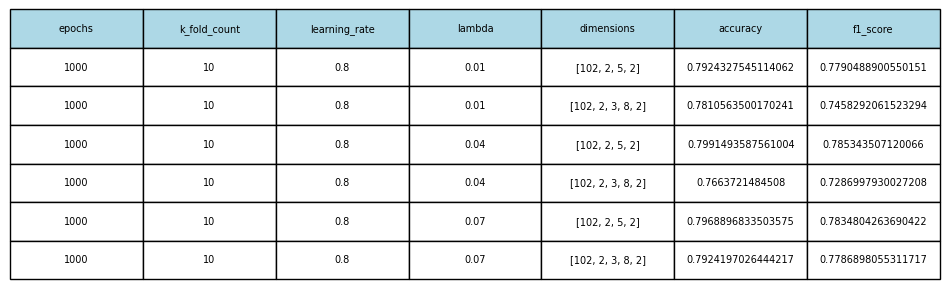

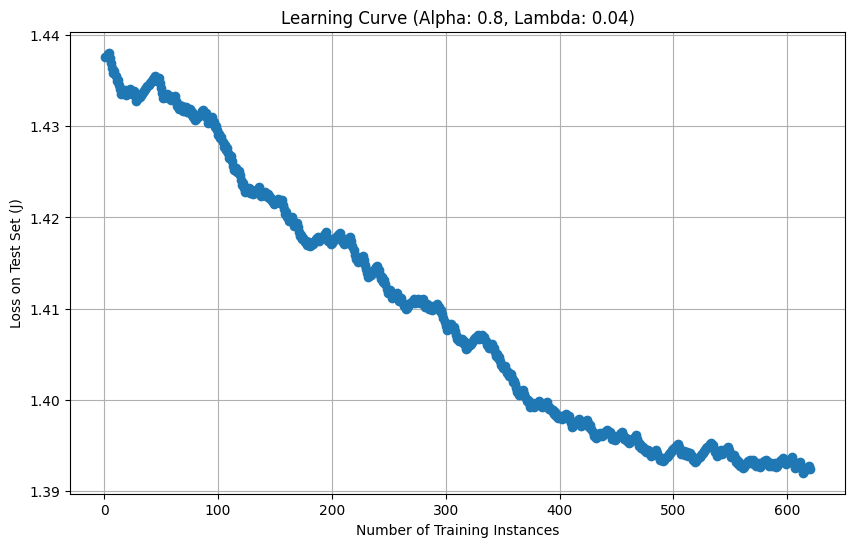

In [20]:
################# TITANIC DATASET #################
print("################# TITANIC DATASET #################\n")
FILE_PATH = "dataset/titanic.csv"  
ld = loadDataset()
dataset = normalizeDataset(ld)
class_label = np.sort(unique(dataset[:, -1]))
cat_cols = [True, False, True, True, False, False]
dataset = hotEncode(dataset, cat_cols)

results = []
best_accuracy = 0
best_configuration = None

learning_rate = .8
epochs = 1000
k = 10

dimensions = [[dataset.shape[1]-1, 2, 5, 2], [dataset.shape[1]-1, 2, 3, 8, 2]]
lamb = [0.01, 0.04, 0.07]

for l in lamb:
    for dimn in dimensions:
        Model = Neural_Network(learning_rate, l, epochs)
        accur, f1sc = Model.run_model(dataset, k, class_label, dimn)
        if accur > best_accuracy:
            best_accuracy = accur
            best_configuration = (dimn, l)
        results.append({
            "epochs": epochs,
            "k_fold_count": k,
            "learning_rate": learning_rate,
            "lambda": l,
            "dimensions": str(dimn),
            "accuracy": accur,
            "f1_score": f1sc
        })

plotTables(results)

if best_configuration:
    dimensions, lamb = best_configuration
    # pass printLogs=True to print intermediate calculations
    Model = Neural_Network(learning_rate, lamb, 1)
    Model.run_model_single_fold(dataset, class_label, dimensions, test_ratio=0.3)